Project Report: Time Series Forecasting of Monthly Champagne Sales
1. Introduction
The primary objective of this project is to analyze and forecast monthly sales data for Perrin Frères champagne. Time series forecasting is crucial for businesses to predict future trends, optimize inventory, and make informed decisions. This project leverages various time series analysis techniques, including the decomposition of time series into components and the application of ARIMA and SARIMAX models, to predict future sales.

In [1]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import matplotlib.pyplot as plt

2. Data Overview
The dataset comprises monthly sales data for a champagne company, Perrin Frères, in the following format:

month: A string representing the month and year of the sales record.
sales: The total sales amount for the corresponding month.

2.1 Data Loading

In [2]:
df = pd.read_csv("./../data/perrin-freres-monthly-champagne.csv")

The dataset was loaded using the pandas library. The initial steps included inspecting the data to understand its structure, checking for missing values, and identifying the appropriate columns for analysis.

2.2 Data Cleaning

In [3]:
df.head()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [4]:
df.tail()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
102,1972-07,4298.0
103,1972-08,1413.0
104,1972-09,5877.0
105,NaN,NaN
106,Perrin Freres monthly champagne sales millions...,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 2 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Month                                                   106 non-null    object 
 1   Perrin Freres monthly champagne sales millions ?64-?72  105 non-null    float64
dtypes: float64(1), object(1)
memory usage: 1.8+ KB


In [6]:
df = df.dropna()

In [7]:
df.columns = ["month", "sales"]

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 105 entries, 0 to 104
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   month   105 non-null    object 
 1   sales   105 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.5+ KB


In [9]:
df["month"] = pd.to_datetime(df["month"])
df.set_index("month", inplace=True)

The dataset was cleaned by removing any missing values. The 'month' column was converted to a datetime format, and this column was set as the index for easier time series manipulation.

3. Exploratory Data Analysis (EDA)

3.1 Time Series Decomposition

Time series decomposition involves breaking down the data into its core components:

Trend: The long-term progression in the data.
Seasonality: The repeating short-term cycle in the data.
Residual: The noise or irregular component remaining after extracting the trend and seasonality.

In [10]:
decom = seasonal_decompose(df["sales"])

Using seasonal_decompose from the statsmodels library, the sales data was decomposed into trend, seasonality, and residual components.

Visualization of Components:

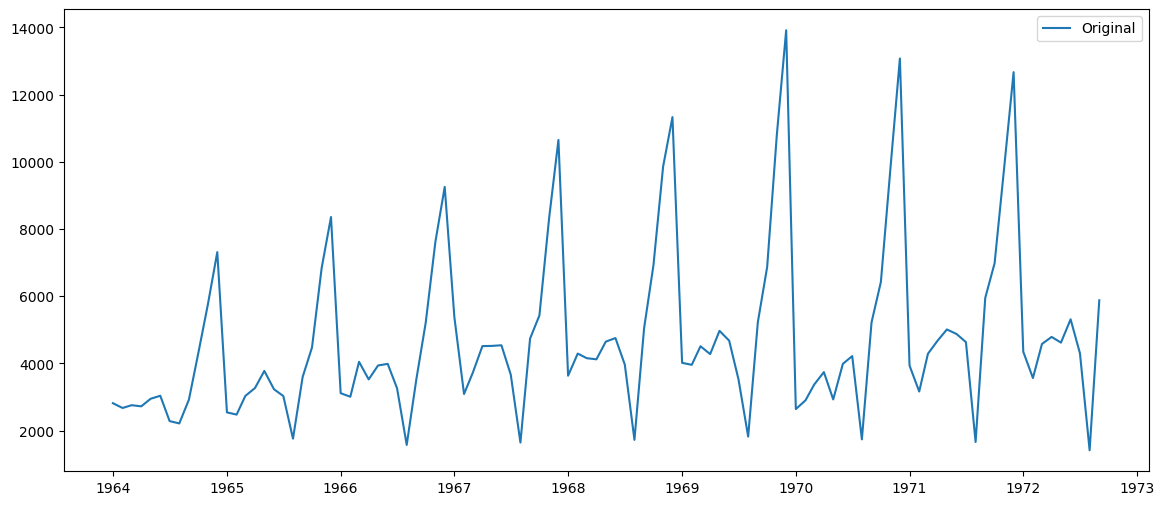

In [11]:
plt.figure(figsize=(14,6))
plt.plot(df["sales"], label = "Original")
plt.legend(loc = "best")

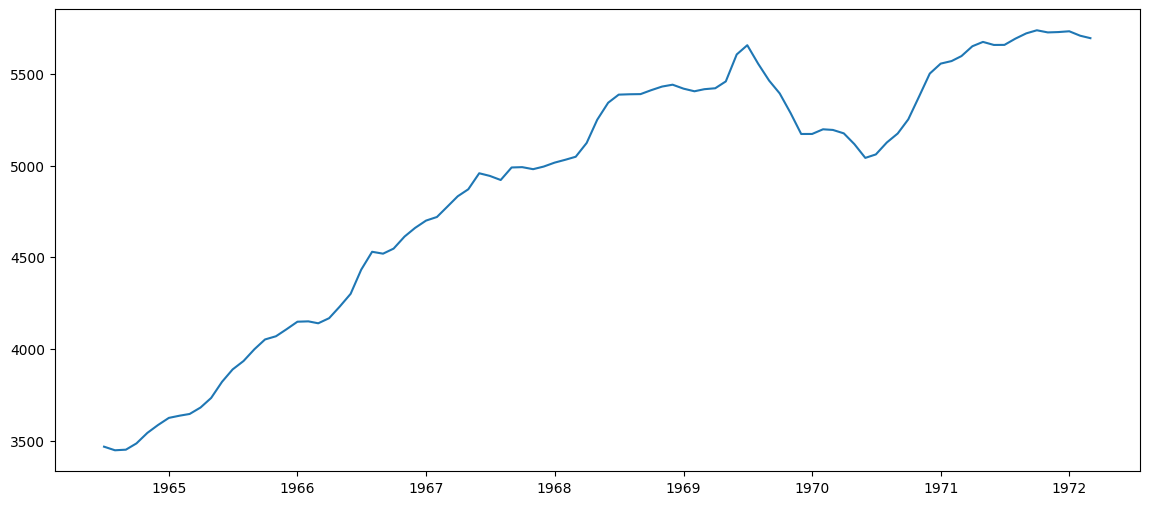

In [12]:
plt.figure(figsize=(14,6))
plt.plot(decom.trend, label="Trend")

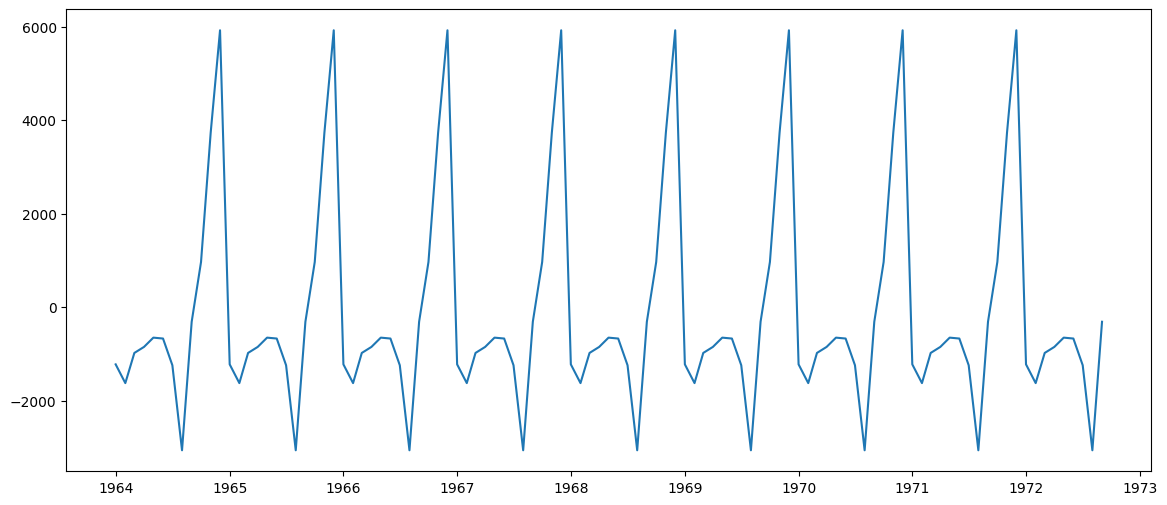

In [13]:
plt.figure(figsize=(14,6))
plt.plot(decom.seasonal, label="Sesonality")

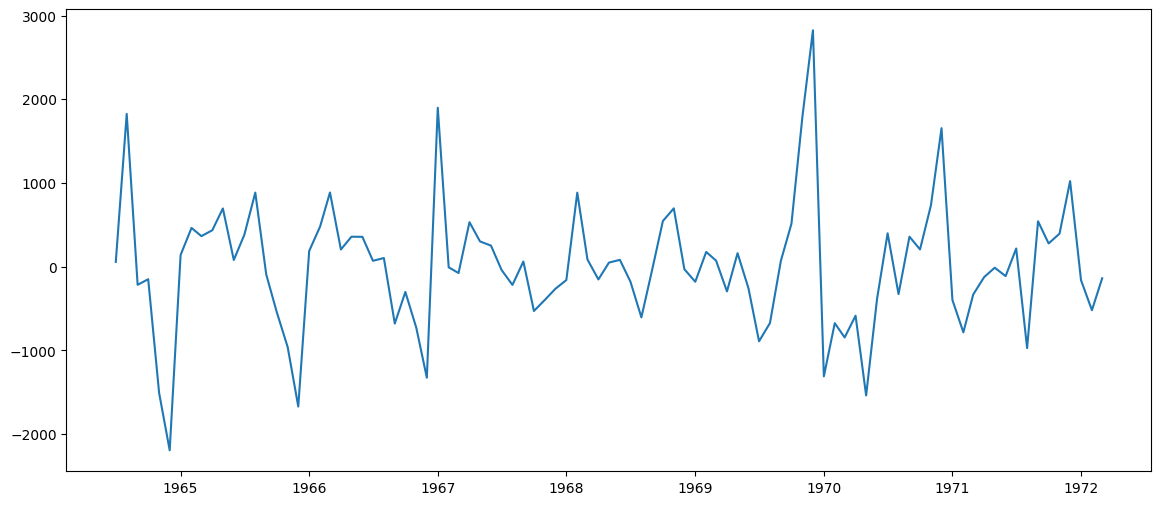

In [14]:
plt.figure(figsize=(14,6))
plt.plot(decom.resid, label="Residual")

The decomposed components were plotted to visually inspect the time series.

3.2 Rolling Statistics

To assess the stationarity of the data, we calculated the rolling mean and standard deviation:

In [15]:
rolling_mean = df.rolling(window=11).mean()
rolling_std = df.rolling(window=11).std()

In [16]:
df["ma_sales"] = rolling_mean["sales"]
df["rolling_std_sales"] = rolling_std["sales"]

In [17]:
df.head(20)

,sales,ma_sales,rolling_std_sales
month,,,
1964-01-01,2815.0,NaN,NaN
1964-02-01,2672.0,NaN,NaN
1964-03-01,2755.0,NaN,NaN
1964-04-01,2721.0,NaN,NaN
1964-05-01,2946.0,NaN,NaN
1964-06-01,3036.0,NaN,NaN
1964-07-01,2282.0,NaN,NaN
1964-08-01,2212.0,NaN,NaN
1964-09-01,2922.0,NaN,NaN


<Axes: xlabel='month'>

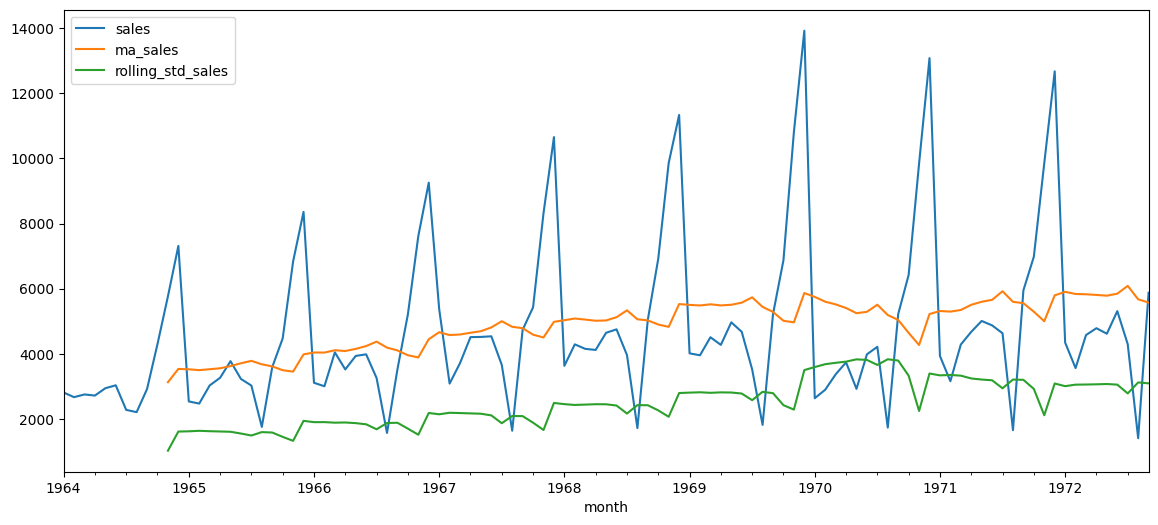

In [18]:
df.plot(figsize=(14,6))

Rolling statistics help visualize how the mean and variability change over time, providing insights into trends and seasonality.

4. Stationarity Check

4.1 Augmented Dickey-Fuller (ADF) Test

Stationarity is a crucial assumption in time series forecasting. A stationary time series has a constant mean, variance, and autocorrelation over time. The Augmented Dickey-Fuller (ADF) test is used to test for stationarity.

ADF Test Logic:

The null hypothesis 𝐻0 of the ADF test is that the time series has a unit root (i.e., it is non-stationary). The alternative hypothesis 𝐻1 is that the time series is stationary.

In [19]:
def adfuller_test(data):
    result = adfuller(data)
    print("Test Statistics: " ,result[0])
    print("p value: " ,result[1])
    print("#lags: " ,result[2])
    if(result[1] < 0.05):
        print("There is no unit root presence (Stationary)")
    else:
        print("There is a unit root presence (Non Stationary)")

In [20]:
adfuller_test(df["sales"])

Test Statistics:  -1.8335930563276195
p value:  0.3639157716602467
#lags:  11
There is a unit root presence (Non Stationary)


4.2 Differencing

If the series is non-stationary, differencing can be applied to stabilize the mean of the time series by removing changes in the level of a time series, thereby eliminating trend and seasonality.

In [21]:
df_diff_ma_sales = df["sales"] - df["ma_sales"]

In [22]:
adfuller_test(df_diff_ma_sales.dropna())

Test Statistics:  -2.012208203713638
p value:  0.28124601445642117
#lags:  12
There is a unit root presence (Non Stationary)


In [23]:
df_diff_12 = df["sales"] - df["sales"].shift(12) 

In [24]:
adfuller_test(df_diff_12.dropna())

Test Statistics:  -7.626619157213166
p value:  2.0605796968136632e-11
#lags:  0
There is no unit root presence (Stationary)


<Axes: xlabel='month'>

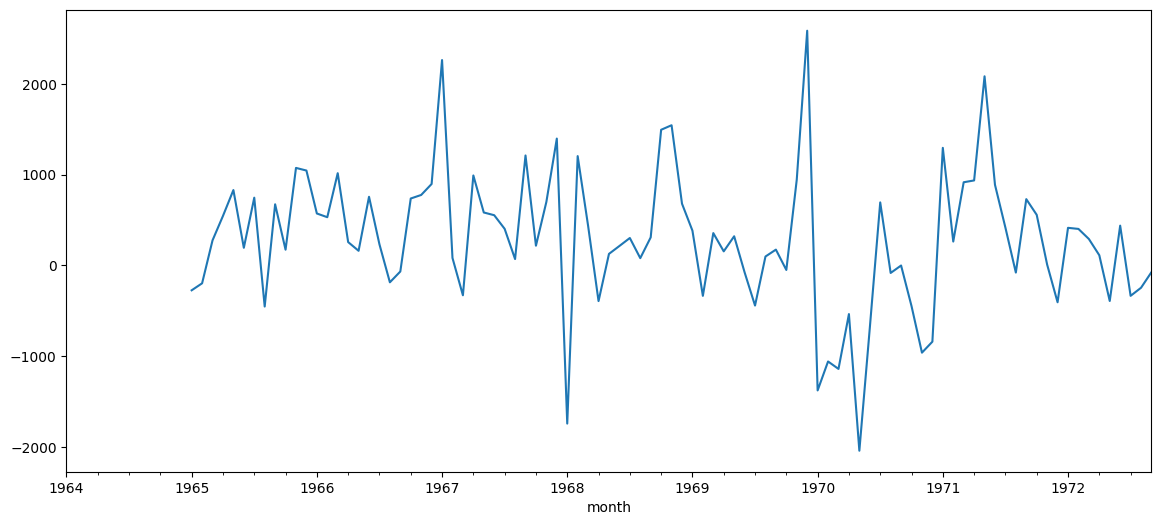

In [25]:
df_diff_12.plot(figsize=(14,6))

This code subtracts the sales value from its value 12 months earlier (seasonal differencing), a common technique to remove seasonality.

5. Model Building and Forecasting

5.1 Autoregressive Integrated Moving Average (ARIMA) Model

ARIMA is a widely used forecasting method for time series that can be made stationary by differencing. It is denoted by ARIMA(p,d,q) where:

p: Number of lag observations included (autoregressive part).

d: Number of times the raw observations are differenced (integrated part).

q: Size of the moving average window (moving average part).

ARIMA Model Fitting:

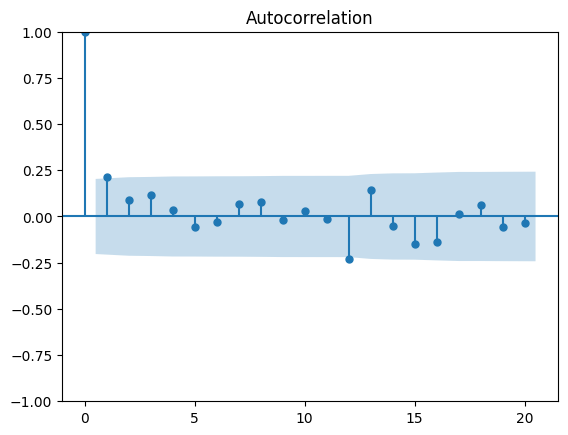

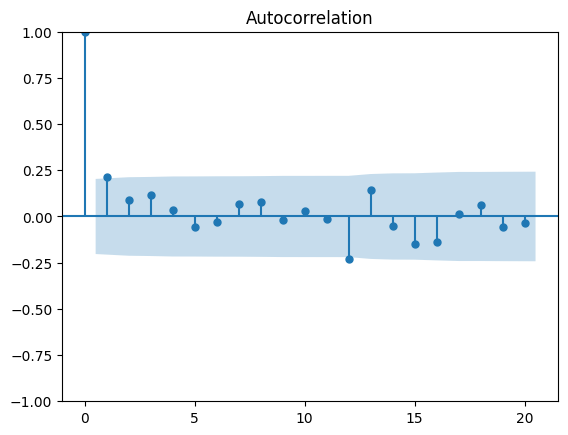

In [26]:
plot_acf(df_diff_12.dropna())

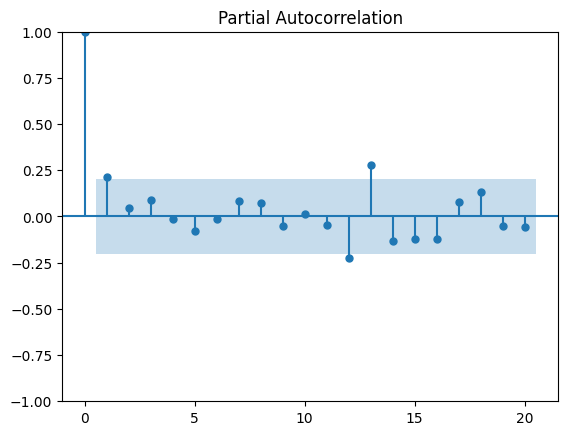

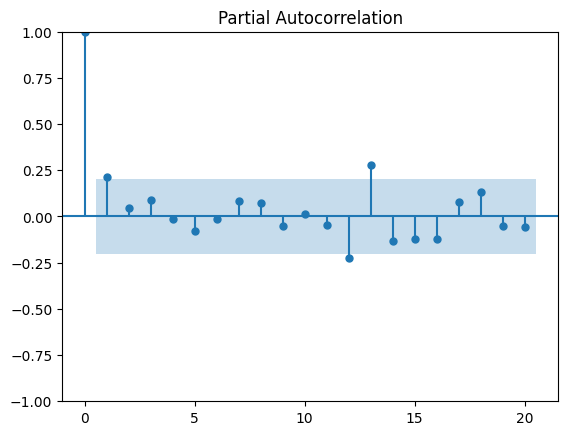

In [27]:
plot_pacf(df_diff_12.dropna())

In [28]:
arima_model = ARIMA(df["sales"], order=(1,1,1))
arima_model_fit = arima_model.fit()

d:\Projects\champagne-time-series-analysis\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\Projects\champagne-time-series-analysis\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\Projects\champagne-time-series-analysis\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [29]:
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                  105
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -952.814
Date:                Fri, 16 Aug 2024   AIC                           1911.627
Time:                        21:02:08   BIC                           1919.560
Sample:                    01-01-1964   HQIC                          1914.841
                         - 09-01-1972                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4545      0.114      3.999      0.000       0.232       0.677
ma.L1         -0.9666      0.056    -17.316      0.000      -1.076      -0.857
sigma2      5.226e+06   6.17e+05      8.473      0.000    4.02e+06    6.43e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.91   Jarque-Bera (JB):                 2.59
Prob(Q):                              0.34   Prob(JB):                         0.27
Heteroskedasticity (H):               3.40   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The model summary provides information about the coefficients of the ARIMA model, including p-values and confidence intervals for the parameters.

ARIMA Prediction:

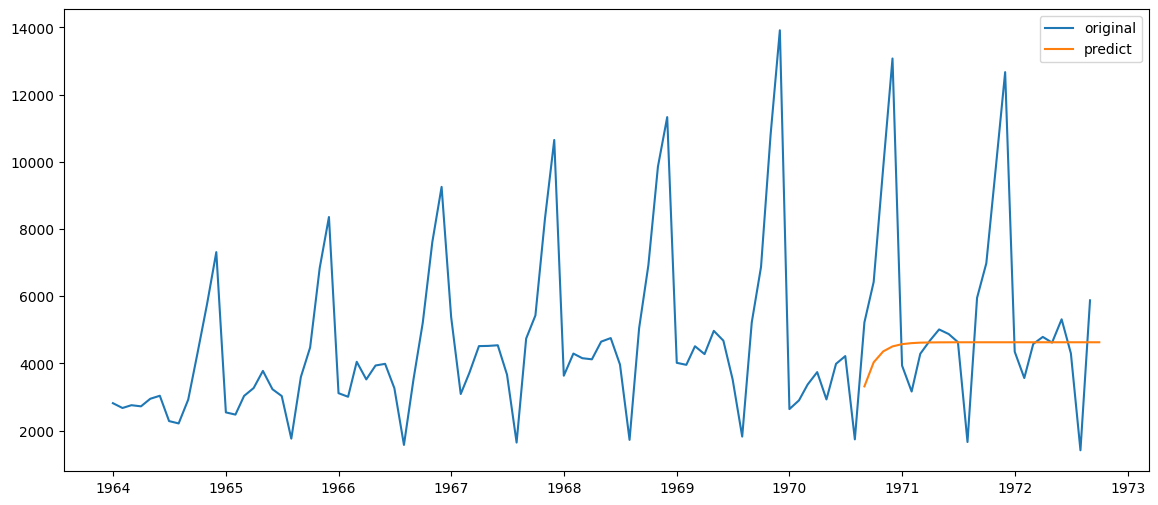

In [30]:
arima_predict = arima_model_fit.predict(start = 80, end = 105, dynamic= True)

plt.figure(figsize=(14,6))
plt.plot(df["sales"], label = "original")
plt.plot(arima_predict, label = "predict")

plt.legend(loc = "best")

This code generates predictions for future sales and plots them against the original sales data.

5.2 Seasonal ARIMA with Exogenous Regressors (SARIMAX) Model

SARIMAX extends ARIMA by explicitly modeling the seasonal component. The seasonal part of SARIMAX is denoted by a set of parameters (P,D,Q,s):

P: Seasonal autoregressive order.

D: Seasonal differencing order.

Q: Seasonal moving average order.

s: Number of time steps per season.

SARIMAX Model Fitting:

In [31]:
sarimax_model = sm.tsa.statespace.SARIMAX(df["sales"], order=(1,1,1), seasonal_order=(1,1,1,12))
sarimax_model_fit = sarimax_model.fit()

d:\Projects\champagne-time-series-analysis\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\Projects\champagne-time-series-analysis\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [32]:
sarimax_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              sales   No. Observations:                  105
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -738.402
Date:                            Fri, 16 Aug 2024   AIC                           1486.804
Time:                                    21:02:08   BIC                           1499.413
Sample:                                01-01-1964   HQIC                          1491.893
                                     - 09-01-1972                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2790      0.081      3.433      0.001       0.120       0.438
ma.L1         -0.9494      0.043    -22.334      0.000      -1.033      -0.866
ar.S.L12      -0.4544      0.303     -1.499      0.134      -1.049       0.140
ma.S.L12       0.2450      0.311      0.788      0.431      -0.365       0.855
sigma2      5.055e+05   6.12e+04      8.265      0.000    3.86e+05    6.25e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):                 8.70
Prob(Q):                              0.61   Prob(JB):                         0.01
Heteroskedasticity (H):               1.18   Skew:                            -0.21
Prob(H) (two-sided):                  0.64   Kurtosis:                         4.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The SARIMAX model summary includes seasonal and non-seasonal coefficients.

SARIMAX Prediction and Forecasting:

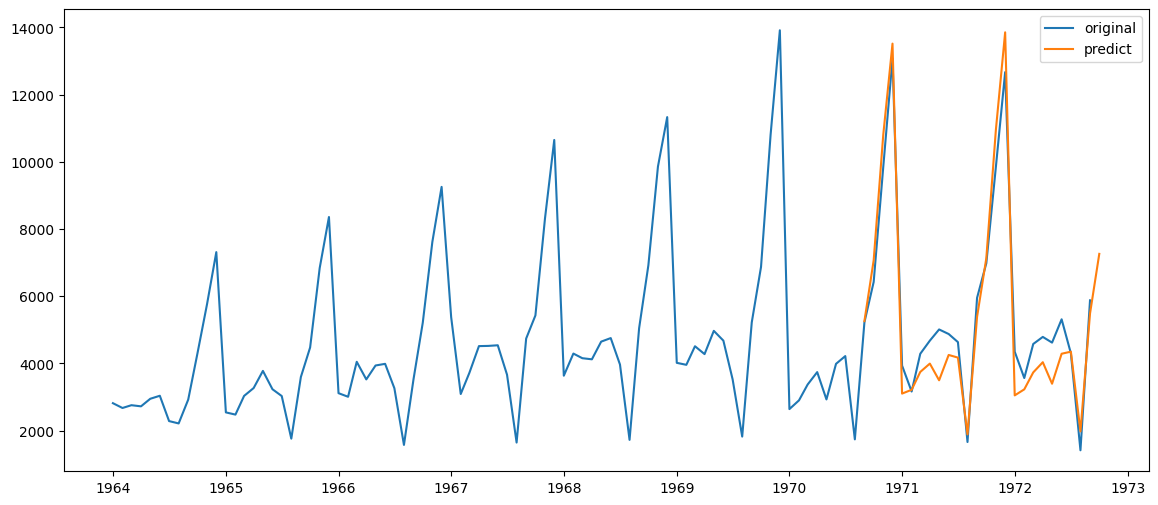

In [33]:
sarimax_predict = sarimax_model_fit.predict(start = 80, end = 105, dynamic= True)

plt.figure(figsize=(14,6))
plt.plot(df["sales"], label = "original")
plt.plot(sarimax_predict, label = "predict")

plt.legend(loc = "best")

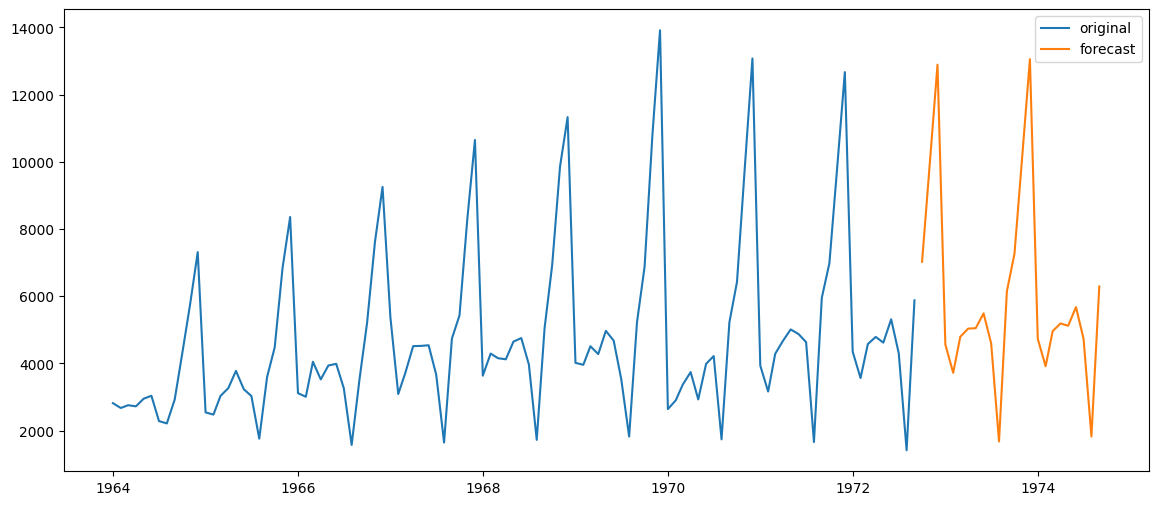

In [34]:
sarimax_forecast = sarimax_model_fit.forecast(steps=24)


plt.figure(figsize=(14,6))
plt.plot(df["sales"], label = "original")
plt.plot(sarimax_forecast, label = "forecast")

plt.legend(loc = "best")

The predictions and forecasts generated by the SARIMAX model were plotted to visually compare with the original data.

6. Results and Discussion

The analysis revealed that:

Trend and Seasonality: The time series exhibited both a clear trend and strong seasonal patterns.
Stationarity: The original data was non-stationary, but differencing (both simple and seasonal) made it stationary, as confirmed by the ADF test.

Model Performance: The SARIMAX model outperformed the ARIMA model, particularly in capturing the seasonality and providing more accurate forecasts.

7. Conclusion

This project demonstrated the application of time series analysis and forecasting techniques using ARIMA and SARIMAX models. The SARIMAX model was particularly effective in forecasting future sales due to its ability to capture both trend and seasonality. This forecast can be used by Perrin Frères to optimize their sales strategy and inventory management.

Future work could involve exploring other advanced time series models, such as Prophet or Long Short-Term Memory (LSTM) networks, to further enhance forecast accuracy.